## Accessing the data and simple stats of the emails

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('messages.csv')

print(f"Number of email threads {len(df)}")
df.describe()

Number of email threads 1040


,Path,FileName,From,To,Sent,Subject,Content
count,1040,1040,921,924,1040,861,822
unique,1040,977,130,210,847,208,686
top,pdfs/kronprinsessen/EFTA01772496.pdf,EFTA02150944.pdf,H.K.H. Kronprinsessen,Jeffrey Epstein jeevacation@gmail.com,2013-06-28T21:37:00+0000,Re:,H Xmas
freq,1,2,154,173,18,359,5


## Cleaning up To and From fields
These kinds of people are notorious for using various aliases and different emails.
This code attempts to consolidate all emails to their known aliases, in addition to reduce parsing errors.

In [44]:

known_people = {
    'boris' : "Boris Nikolic", 
    'jeff' : "Jeffrey Epstein",
    'kpm' : "H.K.H. Kronprinsessen",
    'kronprinsessen' : "H.K.H. Kronprinsessen",
    'casanova' : "Gerry Casanova",
    'lesley' : "Lesley Groff",
}

def is_known(name):
    for alias in known_people.keys():
        if alias in name:
            return alias
    return ""

for i, row in df.iterrows():
    if isinstance(row['From'], str) and isinstance(row["To"], str):
        sender = row['From'].replace("\"", "")
        recipient = row['To'].replace("\"", "")
        if is_known(sender.lower()) != "":
            df.loc[i, 'From'] = known_people[is_known(sender.lower())]
        if is_known(recipient.lower()) != "":
            df.loc[i, 'To'] = known_people[is_known(recipient.lower())]

df[['From', 'To']]

,From,To
0,NaN,vacation@gmail.com[jeevacation@gmail.com]; Jef...
1,H.K.H. Kronprinsessen,Jeffrey Epstein
2,H.K.H. Kronprinsessen,Jeffrey Epstein
3,H.K.H. Kronprinsessen,Jeffrey Epstein
4,H.K.H. Kronprinsessen,Jeffrey Epstein
...,...,...
1035,Boris Nikolic,Jeffrey Epstein
1036,Jeffrey Epstein,Boris Nikolic
1037,Gerry Casanova,Jeffrey Epstein
1038,Gerry Casanova,Jeffrey Epstein


## Cleaning up the dates and creating a timeline of emails

In [34]:

df.loc[0, 'Sent'] = str(datetime(2012, 12, 10))
df['Sent'] = pd.to_datetime(df['Sent'], format='mixed', utc=True)
for i, row in df.iterrows():
    date = row['Sent']
    if date.year == 2026 or date.year == 2002: # Remove Outliers
        df.loc[i, 'Sent'] = pd.Timestamp('NaT') # These dates are wrongly parsed so set them to NaT
df['Sent']

0      2012-12-10 00:00:00+00:00
1                            NaT
2                            NaT
3                            NaT
4                            NaT
                  ...           
1035   2011-05-10 16:56:00+00:00
1036   2011-05-10 01:01:00+00:00
1037   2009-05-13 22:17:25+00:00
1038   2009-05-13 22:17:25+00:00
1039                         NaT
Name: Sent, Length: 1040, dtype: datetime64[ns, UTC]

In [35]:
first = min(df['Sent'])
last = max(df['Sent'])
print(first, last)

2009-05-13 22:17:25+00:00 2020-07-22 10:32:13+00:00


[2, 0, 75, 354, 486, 86, 0, 0, 2, 3, 17, 6]


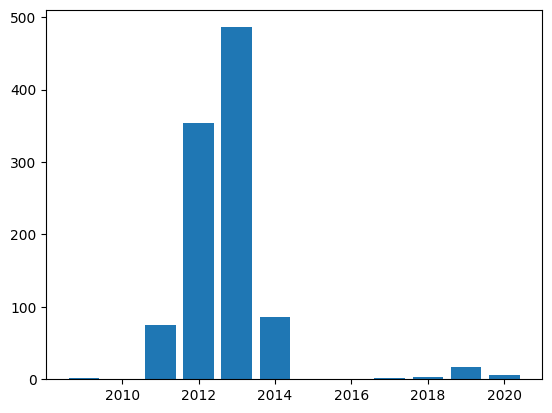

In [12]:
time_line = []
counts = []
for year in range(first.year, last.year + 1):
    time_line.append(year)
    counts.append(0)


for i, corr in df.iterrows():
    if pd.isna(corr['Sent']):
        continue
    index = corr['Sent'].year - first.year
    counts[index] += 1

print(counts)
plt.bar(time_line, counts)
plt.show()

In [45]:
import re

filler_words = ["sendt","wrote", "h", "kl", "b", "c", "y", "de", "o", "u", "f", "june", "propertylist", "label", "z", "la", "sg", "j", "f", "t", "q","g","n", "encoding", "utf", "let", "doctype", "tue", ";", "d", "array", "dtd", "efta_r1_01", "apple", "date", "l","en", "id","string", "d" "y", "le", "x", "00pm", "w", "je", "re","s", "ce", "m", "p", "e", "kl.", "oct", "okt", "cc", "version", "xml", "version", "des", "tue", "thu", "mon", "dict", "den", "dec", "plist", "wed", "sun", "fri", "sat", "pm", "jan", "<jeevacation@gmail.com>:", "<jccvacationagmail.com>", "<mailto:jeevacation@gmail.com»:", "<jeevacation@gmail.com", "feb", "mar", "apr", "key", "integer", "sep", "mai", "jun", "jul", "aug", "nov" "des",  "skrev", "gmail", "mailto", "subject", "sent", "sendt", "jeevacation"]

def filter_text(text, words):
    return " ".join(
        w for w in re.findall(r"\b\w+\b", text)
        if w.lower() not in words
    )

all_content = ""
for i, row in df.iterrows():
    mail_content = str(row['Content'])
    filtered = filter_text(mail_content, [w.lower() for w in filler_words])
    all_content += filtered



# Creating a Wordcloud of all Email Content
The following snippet creates a wordcloud of all the email contents. Unsuprisingly names are the most common words

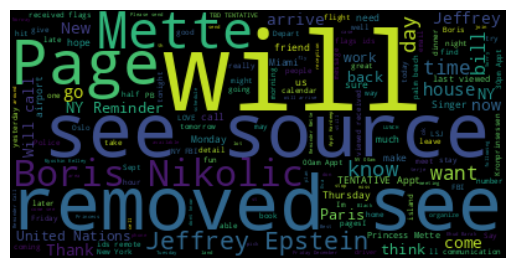

In [14]:
wordcloud = WordCloud().generate(all_content)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Displaying email content

In [ ]:
def print_email(i):
    print("===============================")
    print(f"From: {df.loc[i, 'From']}")
    print(f"To: {df.loc[i, 'To']}")
    print(f"Subject: {df.loc[i, 'Subject']}  Date: {df.loc[i, 'Sent']}")
    print()
    print(df.loc[i, 'Content'])
    print("===============================")
print_email(0)

In [ ]:
for i, row in df.iterrows():
    subject = row['Subject']
    if not pd.isna(subject) and len(subject) > 3:
        print_email(i)

## Exporting CSV based on senders

In [51]:
def all_correspondence(p1, p2):
    q = f"(From == '{p1}' and To == '{p2}') or (From == '{p2}' and To == '{p1}')"
    return df.query(q)

kmp_jeff = all_correspondence('Jeffrey Epstein', 'H.K.H. Kronprinsessen')
lg_jeff = all_correspondence('Jeffrey Epstein', 'Lesley Groff')
bor_jeff = all_correspondence('Boris Nikolic', 'Jeffrey Epstein')
bor_kmp = all_correspondence('Boris Nikolic', 'H.K.H. Kronprinsessen')
lg_kmp = all_correspondence('Lesley Groff', 'H.K.H. Kronprinsessen')

kmp_jeff.to_csv('mette_jeff.csv', index=False)
lg_jeff.to_csv('lesley_jeff.csv', index=False)
bor_jeff.to_csv('boris_jeff.csv', index=False)
bor_kmp.to_csv('boris_mette.csv', index=False)
lg_kmp.to_csv('lesley_mette.csv', index=False)


